# DEEP LEARMING

In [1]:
from google.colab import drive
import os
import glob
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import warnings
from collections import Counter

In [2]:
# Montar Drive.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Ruta a las imágenes
ruta_animales = '/content/drive/MyDrive/Animales/dogs-vs-cats/train'
ruta_animales = ruta_animales.replace('\\', '/')

Total perros: 12500
Total gatos: 12500


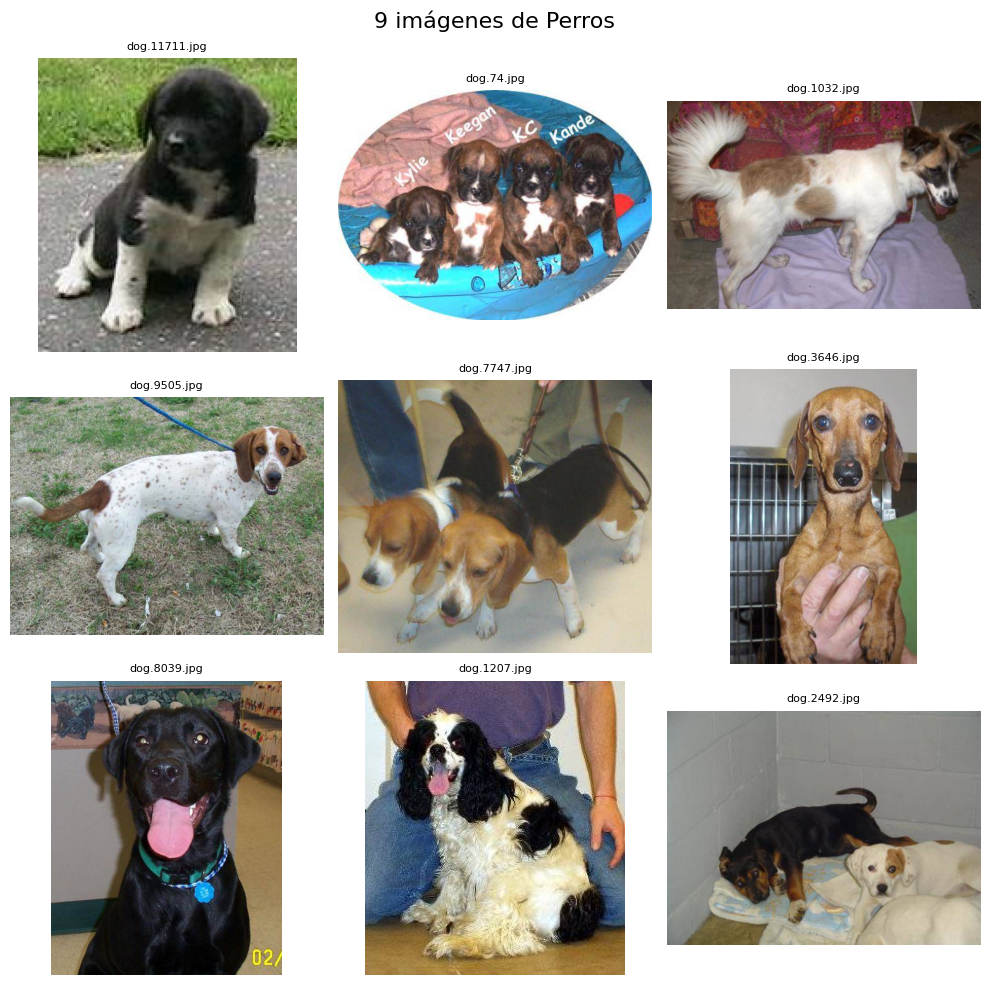

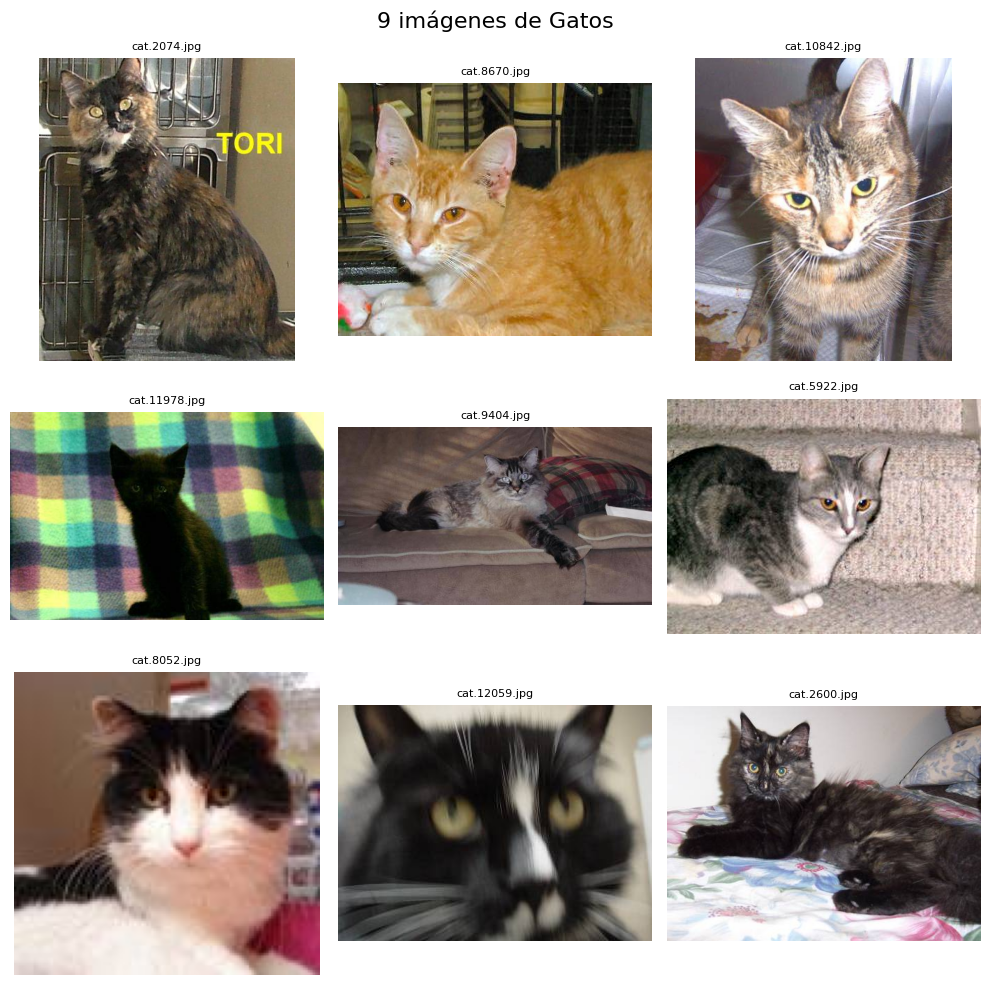

In [17]:
# Mostrar 9 imagenes aleatorias.
def mostrar_imagenes(imagenes, titulo):
    plt.figure(figsize=(10, 10))
    for i in range(len(imagenes)):
        img_path = imagenes[i]
        img = mpimg.imread(img_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(os.path.basename(img_path), fontsize=8)
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()

# Ruta
todas_las_imagenes = glob.glob('/content/drive/MyDrive/Animales/dogs-vs-cats/train/*/*.jpg')

# Filtrar por clase
imagenes_perros = [img for img in todas_las_imagenes if '/dog/' in img.lower()]
imagenes_gatos  = [img for img in todas_las_imagenes if '/cat/' in img.lower()]

# Verificar conteo
print(f"Total perros: {len(imagenes_perros)}")
print(f"Total gatos: {len(imagenes_gatos)}")

# Seleccionar 9 aleatorias de cada tipo
random.shuffle(imagenes_perros)
random.shuffle(imagenes_gatos)

mostrar_imagenes(imagenes_perros[:9], '9 imágenes de Perros')
mostrar_imagenes(imagenes_gatos[:9],  '9 imágenes de Gatos')


In [5]:
# train y test.
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

image_size = (64, 64)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    ruta_animales,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    ruta_animales,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [6]:
# Modelo.
model = Sequential()
model.add(Input(shape=(64, 64, 3)))  # Tamaño de imagen
# Bloque 1
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
# Bloque 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
# Bloque 3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
# Clasificación final
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Dos clases: cats y dogs
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,922 (1.09 MB)

 Trainable params: 285,922 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Compilar el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4), # Afecta a la capacidad predictiva.
    metrics=['accuracy']
)

In [8]:
# Callbacks opcionales para mejor control del entrenamiento
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("mejor_modelo.h5", save_best_only=True)
]

In [9]:
warnings.filterwarnings('ignore')

In [10]:
# Entrenar el modelo
history = model.fit(
  train_generator,
  validation_data=val_generator,
  steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size,
  epochs=20,
  callbacks=callbacks
  )

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.5115 - loss: 0.6985

625/625 ━━━━━━━━━━━━━━━━━━━━ 404s 638ms/step - accuracy: 0.5115 - loss: 0.6985 - val_accuracy: 0.5591 - val_loss: 0.6905
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.5506 - loss: 0.6865

625/625 ━━━━━━━━━━━━━━━━━━━━ 238s 380ms/step - accuracy: 0.5507 - loss: 0.6865 - val_accuracy: 0.6358 - val_loss: 0.6602
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.6165 - loss: 0.6570

625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 386ms/step - accuracy: 0.6165 - loss: 0.6569 - val_accuracy: 0.6569 - val_loss: 0.6387
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6468 - loss: 0.6348

625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 419ms/step - accuracy: 0.6468 - loss: 0.6348 - val_accuracy: 0.6799 - val_loss: 0.6190
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6532 - loss: 0.6316

625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 378ms/step - accuracy: 0.6532 - loss: 0.6315 - val_accuracy: 0.6829 - val_loss: 0.6078
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.6643 - loss: 0.6144

625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 379ms/step - accuracy: 0.6643 - loss: 0.6144 - val_accuracy: 0.6969 - val_loss: 0.5948
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6753 - loss: 0.6025

625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 375ms/step - accuracy: 0.6753 - loss: 0.6025 - val_accuracy: 0.6869 - val_loss: 0.5879
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.6766 - loss: 0.5982

625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 419ms/step - accuracy: 0.6766 - loss: 0.5982 - val_accuracy: 0.7021 - val_loss: 0.5772
Epoch 9/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6879 - loss: 0.5907

625/625 ━━━━━━━━━━━━━━━━━━━━ 295s 376ms/step - accuracy: 0.6879 - loss: 0.5907 - val_accuracy: 0.6999 - val_loss: 0.5750
Epoch 10/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.6919 - loss: 0.5829

625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - accuracy: 0.6919 - loss: 0.5829 - val_accuracy: 0.7171 - val_loss: 0.5648
Epoch 11/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 381ms/step - accuracy: 0.7021 - loss: 0.5761 - val_accuracy: 0.6959 - val_loss: 0.5704
Epoch 12/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7019 - loss: 0.5718

625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 418ms/step - accuracy: 0.7019 - loss: 0.5718 - val_accuracy: 0.7342 - val_loss: 0.5548
Epoch 13/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 378ms/step - accuracy: 0.7052 - loss: 0.5617 - val_accuracy: 0.6955 - val_loss: 0.5650
Epoch 14/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.7094 - loss: 0.5592

625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 370ms/step - accuracy: 0.7094 - loss: 0.5592 - val_accuracy: 0.7226 - val_loss: 0.5459
Epoch 15/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7098 - loss: 0.5566

625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 375ms/step - accuracy: 0.7098 - loss: 0.5566 - val_accuracy: 0.7370 - val_loss: 0.5376
Epoch 16/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7120 - loss: 0.5542

625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - accuracy: 0.7120 - loss: 0.5542 - val_accuracy: 0.7378 - val_loss: 0.5280
Epoch 17/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7230 - loss: 0.5437

625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 379ms/step - accuracy: 0.7230 - loss: 0.5437 - val_accuracy: 0.7338 - val_loss: 0.5276
Epoch 18/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7323 - loss: 0.5372

625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 374ms/step - accuracy: 0.7323 - loss: 0.5372 - val_accuracy: 0.7390 - val_loss: 0.5207
Epoch 19/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7319 - loss: 0.5380

625/625 ━━━━━━━━━━━━━━━━━━━━ 261s 373ms/step - accuracy: 0.7319 - loss: 0.5380 - val_accuracy: 0.7384 - val_loss: 0.5176
Epoch 20/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7262 - loss: 0.5371

625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 373ms/step - accuracy: 0.7263 - loss: 0.5371 - val_accuracy: 0.7366 - val_loss: 0.5166


In [11]:
# Evaluacion del modelo final.
mejor_modelo = load_model("mejor_modelo.h5")
loss, acc = mejor_modelo.evaluate(val_generator)
print(f"Precisión evaluada directamente: {acc:.2%}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.7407 - loss: 0.5107
Precisión evaluada directamente: 73.48%


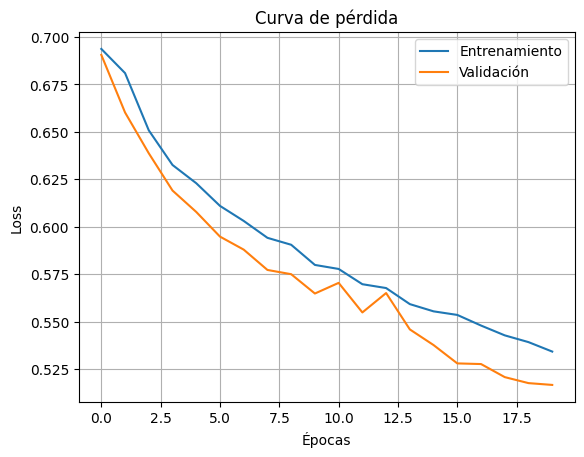

In [12]:
# Visualizar la pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Curva de pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

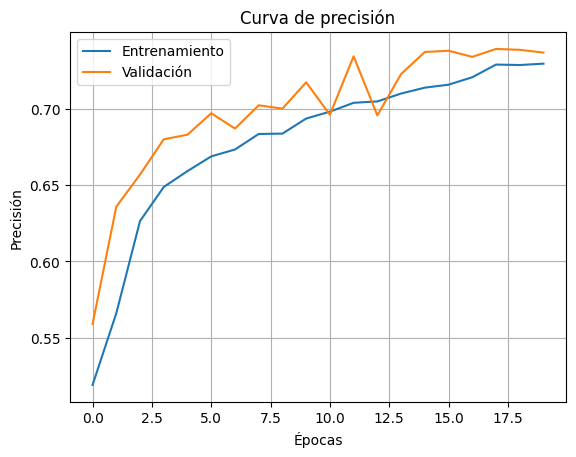

In [13]:
# Visualizar el rendimiento.
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Curva de precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()

156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 235ms/step


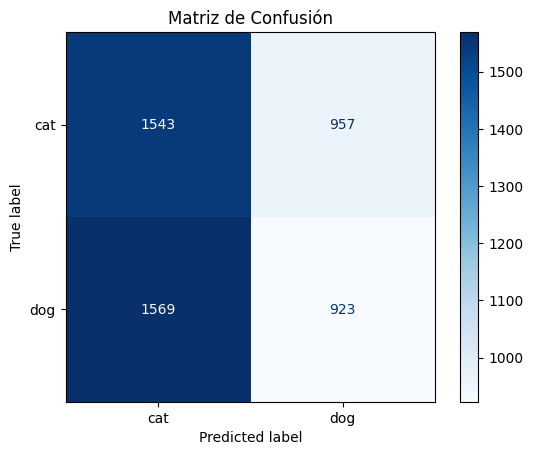

Reporte de clasificación:
              precision    recall  f1-score   support

         cat       0.50      0.62      0.55      2500
         dog       0.49      0.37      0.42      2492

    accuracy                           0.49      4992
   macro avg       0.49      0.49      0.49      4992
weighted avg       0.49      0.49      0.49      4992



In [14]:
# Predicciones del modelo: vectores de probabilidad por clase
y_pred_prob = mejor_modelo.predict(val_generator, steps=val_generator.samples // val_generator.batch_size, verbose=1)
# Convertir a clase predicha: índice del máximo valor
y_pred = np.argmax(y_pred_prob, axis=1)

# Etiquetas verdaderas
y_true = val_generator.classes[:len(y_pred)]

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.grid(False)
plt.show()

# Reporte de clasificación con métricas completas
print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

In [15]:
# Visualizacion de errores.
class_names = list(val_generator.class_indices.keys())

# Índices de errores
errores_idx = np.where(y_pred != y_true)[0]

# Contadores.
errores_cat_como_dog = 0
errores_dog_como_cat = 0

for idx in errores_idx:
    verdadero = y_true[idx]
    predicho = y_pred[idx]
    if verdadero == 0 and predicho == 1:
        errores_cat_como_dog += 1
    elif verdadero == 1 and predicho == 0:
        errores_dog_como_cat += 1

# Resultados
total_errores = len(errores_idx)
print(f"Total de errores: {total_errores}")
print(f"- Gatos clasificados como perros: {errores_cat_como_dog}")
print(f"- Perros clasificados como gatos: {errores_dog_como_cat}")
print(f"\nDistribución de errores:")
print(f"{class_names[0]} → {class_names[1]}: {errores_cat_como_dog} ({errores_cat_como_dog / total_errores:.2%})")
print(f"{class_names[1]} → {class_names[0]}: {errores_dog_como_cat} ({errores_dog_como_cat / total_errores:.2%})")


Total de errores: 2526
- Gatos clasificados como perros: 957
- Perros clasificados como gatos: 1569

Distribución de errores:
cat → dog: 957 (37.89%)
dog → cat: 1569 (62.11%)


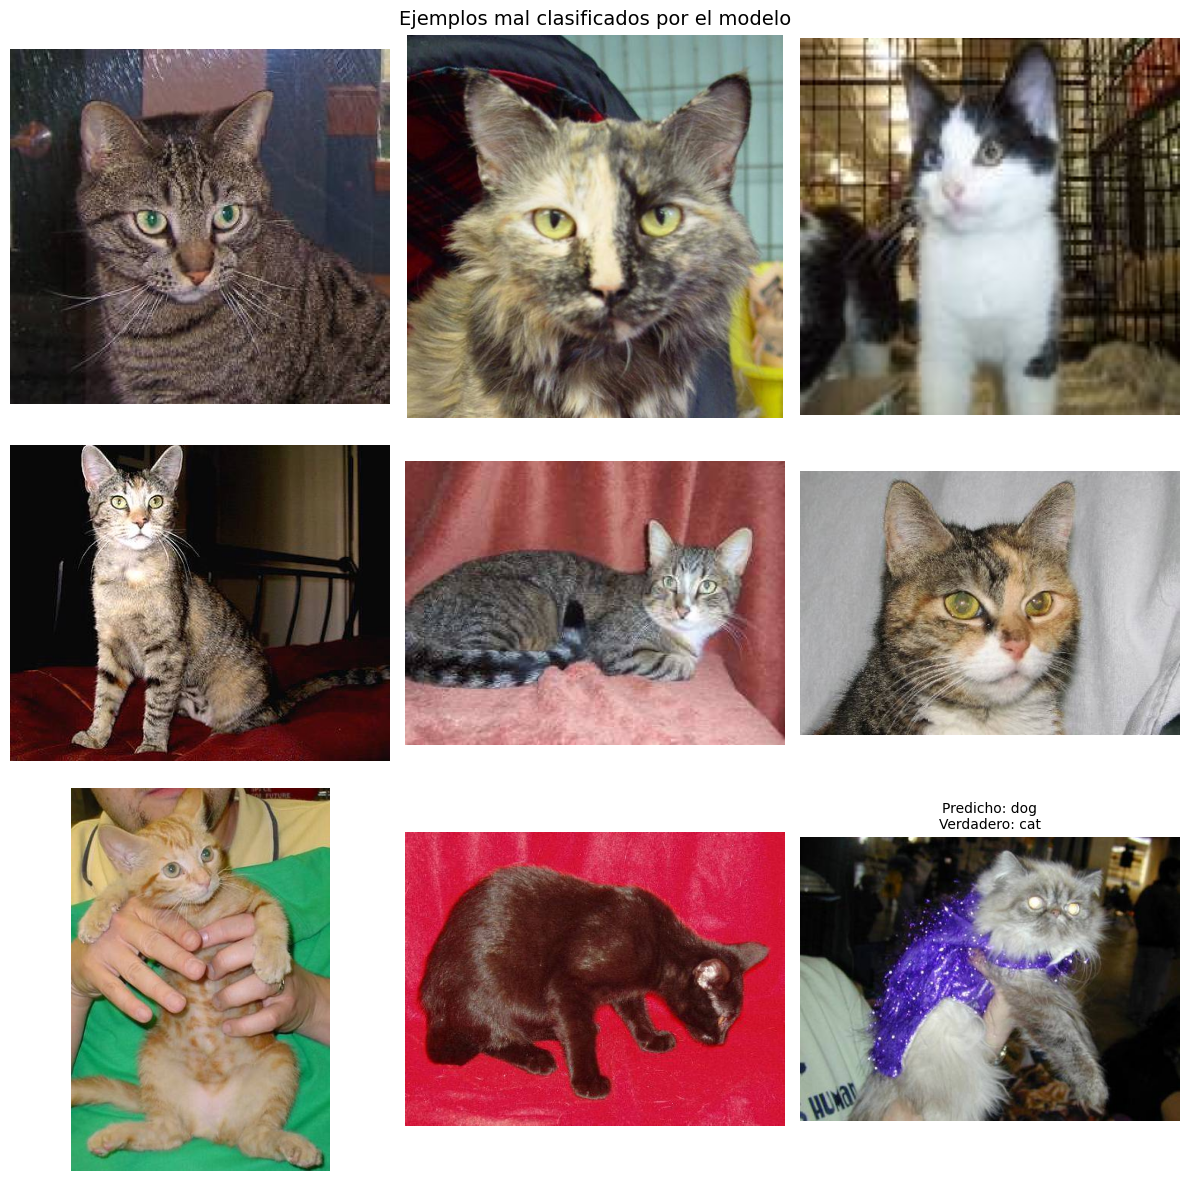

In [16]:
 # Mostrar ejemplos de errores
plt.figure(figsize=(12, 12))
for i, idx in enumerate(errores_idx[:9]):
  img_path = val_generator.filepaths[idx]
  img = mpimg.imread(img_path)

  true_label = class_names[y_true[idx]]
  pred_label = class_names[y_pred[idx]]

  plt.subplot(3, 3, i+1)
  plt.imshow(img)
  plt.axis('off')
plt.title(f"Predicho: {pred_label}\nVerdadero: {true_label}", fontsize=10)
plt.suptitle("Ejemplos mal clasificados por el modelo", fontsize=14)
plt.tight_layout()
plt.show()